<a href="https://colab.research.google.com/github/Waleed-Mujahid/Walmart-Sales-Forecast/blob/main/walmartSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysis and predicting on Walmart Sales Data


In [5]:
# first we load data from drive
!unzip ./drive/MyDrive/walmartSales.zip

Archive:  ./drive/MyDrive/walmartSales.zip
  inflating: features.csv            
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               


In [2]:
# load util functions
!wget https://raw.githubusercontent.com/Waleed-Mujahid/Coding/master/colabUtils.py
import colabUtils as utils

--2022-09-28 14:09:49--  https://raw.githubusercontent.com/Waleed-Mujahid/Coding/master/colabUtils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2206 (2.2K) [text/plain]
Saving to: ‘colabUtils.py’

colabUtils.py       100%[===================>]   2.15K  --.-KB/s    in 0s      

2022-09-28 14:09:50 (17.1 MB/s) - ‘colabUtils.py’ saved [2206/2206]



In [69]:
# Load necessary dependecies
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras
import seaborn as sns
import random

In [6]:
# Reading our dataset into a pandas dataframe
features = pd.read_csv('/content/features.csv', parse_dates = ['Date'])
stores = pd.read_csv('/content/stores.csv')
test = pd.read_csv('/content/test.csv', parse_dates = ['Date'])
train = pd.read_csv('/content/train.csv', parse_dates = ['Date'])

## Looking at our dataset

In [7]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [8]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [9]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [10]:
df = pd.merge(train, stores).merge(features)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Type          421570 non-null  object        
 6   Size          421570 non-null  int64         
 7   Temperature   421570 non-null  float64       
 8   Fuel_Price    421570 non-null  float64       
 9   MarkDown1     150681 non-null  float64       
 10  MarkDown2     111248 non-null  float64       
 11  MarkDown3     137091 non-null  float64       
 12  MarkDown4     134967 non-null  float64       
 13  MarkDown5     151432 non-null  float64       
 14  CPI           421570 non-null  float64       
 15  Unemployment  421

Here we have some missing values so we ignore them for now

In [11]:
df = df.drop(['MarkDown1', 'MarkDown2'	, 'MarkDown3' ,	'MarkDown4','MarkDown5'], axis = 1)

In [12]:
df = df.drop(['Type', 'Size', "Date"], axis = 1)

In [13]:
df = pd.get_dummies(df, columns =  ['IsHoliday'], drop_first =True)
df.head()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_True
0,1,1,24924.50,42.31,2.572,211.096358,8.106,0
1,1,2,50605.27,42.31,2.572,211.096358,8.106,0
2,1,3,13740.12,42.31,2.572,211.096358,8.106,0
3,1,4,39954.04,42.31,2.572,211.096358,8.106,0
4,1,5,32229.38,42.31,2.572,211.096358,8.106,0


## Stationarity of data
Now let us look at our dataset and if it is stationary or not. We will look at the first department of the first store only

In [33]:
first = train.query('Store == 1 and Dept == 1')

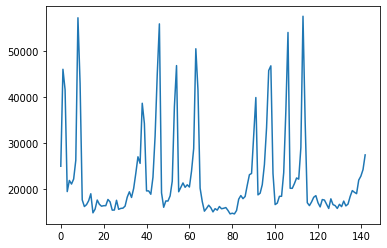

In [15]:
first.Weekly_Sales.plot()

Clearly we can see that the data is not stationary. Now lets take a closer look at the Trends and seasonality of our data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


<Figure size 432x288 with 0 Axes>

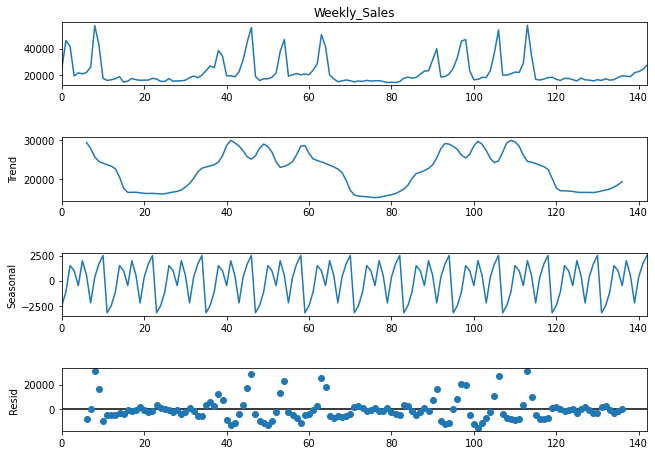

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decomposing Time series
decomposition = seasonal_decompose(first.Weekly_Sales, freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(10, 7)

In [17]:
from statsmodels.tsa.stattools import adfuller
# series = read_csv('daily-total-female-births.csv', header=0, index_col=0, squeeze=True)
X = first.Weekly_Sales.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.522164
p-value: 0.110174
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


As p-value is > 0.05 so the data is not stationary. We can make the data stationary by taking first derivative

In [18]:
stationary = first.diff(periods = 1).dropna()

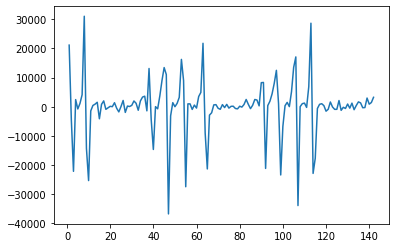

In [19]:
stationary.Weekly_Sales.plot()

We can tell by the graph that the data has becone stationary. Now let us look at it mathamatically

In [20]:
from statsmodels.tsa.stattools import adfuller
X = stationary.Weekly_Sales.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -11.044311
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578


As p-value is zero so data has become statioary

## Training a basic model
### First department of the first store

Here we will try to make a model on the first department of the first store only to check if we are getting good results.

In [34]:
first = pd.merge(first, stores).merge(features)
first = first.drop(['MarkDown1', 'MarkDown2'	, 'MarkDown3' ,	'MarkDown4','MarkDown5','Type', 'Size', "Date", 'Store', 'Dept'], axis = 1)
first = pd.get_dummies(first, columns =  ['IsHoliday'], drop_first =True)
first.head()

,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday_True
0,24924.50,42.31,2.572,211.096358,8.106,0
1,46039.49,38.51,2.548,211.242170,8.106,1
2,41595.55,39.93,2.514,211.289143,8.106,0
3,19403.54,46.63,2.561,211.319643,8.106,0
4,21827.90,46.50,2.625,211.350143,8.106,0


In [37]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import timeseries_dataset_from_array

mms = MinMaxScaler()
mms.fit(first)
X_train = mms.transform(first)
X_train_sc = X_train[:80,:]
X_test = X_train[80:,:]

n_input = 10
generator = timeseries_dataset_from_array(X_train_sc, X_train_sc[:,0],n_input)
test_generator = timeseries_dataset_from_array(X_test, X_test[:,0],n_input)

In [38]:
model = keras.models.Sequential()
model.add(layers.LSTM(64,activation= 'tanh',return_sequences=True, input_shape=(n_input, X_train_sc.shape[1])))
model.add(layers.Dropout(0.25))
model.add(layers.LSTM(10, activation='tanh'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='tanh'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [39]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.mean_squared_error)

In [ ]:
history = model.fit(generator, epochs = 200, validation_data = test_generator)

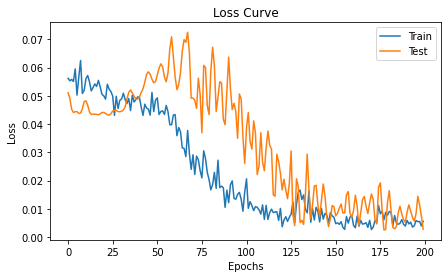

In [179]:
# Plotting the loss curve with helper functions
utils.plotLoss(history,True)

In [180]:
# predicting using the model on train and test data
preds = model.predict(generator)
pred = model.predict(test_generator)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


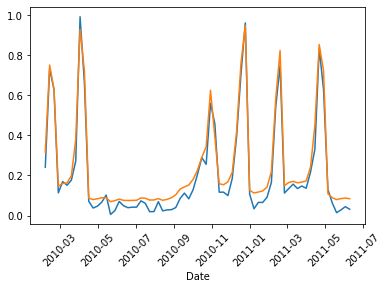

In [181]:
# Looking at the performance of the model on the Train data
val = preds.shape[0]
plt.xticks (rotation = 45)
sns.lineplot(first['Date'].head(val), X_train[:val,0])
sns.lineplot(first['Date'].head(val), preds[:val,0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


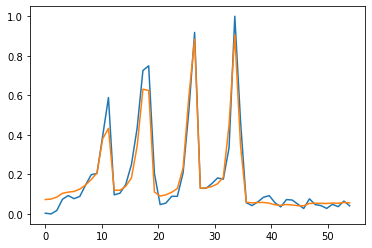

In [191]:
# Looking at the performance of the model on the Test data
sth = pred.shape[0]
order = np.linspace(0,len(X_test),len(X_test))
sns.lineplot(order[:sth], X_test[:sth,0])
sns.lineplot(order[:sth], pred[:,0])

In [183]:
# saving the model to use later
model.save('/content/saved.h5')

In [41]:
# Now let us build a model on the eniter dataset.
# We start by merging the files to get the entire dataset in one Dataframe
data = pd.merge(train, stores).merge(features).drop(['MarkDown1', 'MarkDown2'	, 'MarkDown3' ,	'MarkDown4','MarkDown5'], axis = 1)
data

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,211.096358,8.106
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,211.096358,8.106
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,211.096358,8.106
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,211.096358,8.106
...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,B,118221,58.85,3.882,192.308899,8.667
421566,45,94,2012-10-26,5203.31,False,B,118221,58.85,3.882,192.308899,8.667
421567,45,95,2012-10-26,56017.47,False,B,118221,58.85,3.882,192.308899,8.667
421568,45,97,2012-10-26,6817.48,False,B,118221,58.85,3.882,192.308899,8.667


In [42]:
# Now we want to train for every department of every store separtely
# For this we merge the Store and dept columns to use them as a primary key
data['Store_Dept_code'] = data.apply(lambda x: str(x['Store']) + '-' + str(x['Dept']), axis = 1)

In [43]:
# We can drop the orignal columns as they are redundant
data = data.drop(["Dept", "Store"], axis = 1)

In [44]:
# now let us look at the data we have
data.head()

,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,CPI,Unemployment,Store_Dept_code
0,2010-02-05,24924.50,False,A,151315,42.31,2.572,211.096358,8.106,1-1
1,2010-02-05,50605.27,False,A,151315,42.31,2.572,211.096358,8.106,1-2
2,2010-02-05,13740.12,False,A,151315,42.31,2.572,211.096358,8.106,1-3
3,2010-02-05,39954.04,False,A,151315,42.31,2.572,211.096358,8.106,1-4
4,2010-02-05,32229.38,False,A,151315,42.31,2.572,211.096358,8.106,1-5


In [45]:
# Convert categorical features into numerical ones
new = pd.get_dummies(data, columns = ['IsHoliday', 'Type'], drop_first=True)
new.head()

,Date,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,Store_Dept_code,IsHoliday_True,Type_B,Type_C
0,2010-02-05,24924.50,151315,42.31,2.572,211.096358,8.106,1-1,0,0,0
1,2010-02-05,50605.27,151315,42.31,2.572,211.096358,8.106,1-2,0,0,0
2,2010-02-05,13740.12,151315,42.31,2.572,211.096358,8.106,1-3,0,0,0
3,2010-02-05,39954.04,151315,42.31,2.572,211.096358,8.106,1-4,0,0,0
4,2010-02-05,32229.38,151315,42.31,2.572,211.096358,8.106,1-5,0,0,0


In [46]:
stores_depts = new.Store_Dept_code.unique()
unique_stores_depts = len(stores_depts)

In [47]:
print(f"So we have a total number of {unique_stores_depts} department and stores")

So we have a total number of 3331 department and stores


### Training on the Entire data
We have a time series for every department of every store so first we need to separate them make their time seires. Next we will stack them on each other to make our train data.

In [52]:
new.query('Store_Dept_code == "7-49"')

,Date,Weekly_Sales,Size,Temperature,Fuel_Price,CPI,Unemployment,Store_Dept_code,IsHoliday_True,Type_B,Type_C
59043,2010-02-05,14.15,70713,10.53,2.580,189.381697,9.014,7-49,0,1,0
59114,2010-02-12,16.98,70713,25.90,2.572,189.464272,9.014,7-49,1,1,0
59184,2010-02-19,16.98,70713,27.28,2.550,189.534100,9.014,7-49,0,1,0
59256,2010-02-26,22.64,70713,24.91,2.586,189.601802,9.014,7-49,0,1,0
59327,2010-03-05,11.32,70713,35.86,2.620,189.669505,9.014,7-49,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
68460,2012-09-28,15.94,70713,50.64,3.789,198.590328,7.872,7-49,0,1,0
68528,2012-10-05,36.88,70713,48.43,3.779,198.822132,7.557,7-49,0,1,0
68597,2012-10-12,5.94,70713,41.43,3.760,199.053937,7.557,7-49,0,1,0
68666,2012-10-19,41.88,70713,43.01,3.750,199.148196,7.557,7-49,0,1,0


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import timeseries_dataset_from_array

# python lists to store the time series for each dept-store
features, labels, test_features, test_labels = [], [], [], []

# We loop for the 3331 combinations of stores and dept we have
for val in stores_depts:
  print(val)
  # first we separte the time series for the relevant store and dept
  dataset = new.query('Store_Dept_code == @val')

  # We can drop these columns
  dataset = dataset.drop(["Date", "Store_Dept_code"], axis = 1)

  # next we scale our data
  mms = MinMaxScaler()
  mms.fit(dataset)
  X_train = mms.transform(dataset)  

  # We want atleast 80 datapoints for our dataset
  if(len(X_train) < 80):
    continue

  # First 80 points of the time series are for training the rest are for testing
  X_train_sc = X_train[:55,:]
  X_test = X_train[75:,:]

  # We will look at the last 10 days of data to make prediction
  n_input = 10

  # Making time series for the train and test data
  generator = timeseries_dataset_from_array(X_train_sc, X_train_sc[:,0],n_input)

  # Now we append the time series of the Dept-Store to the train list
  for train_featurres, train_label in generator:
    features.append(train_featurres)
    labels.append(train_label)
  
  if (len(X_train) > 100):
    test_generator = timeseries_dataset_from_array(X_test, X_test[:,0],n_input)
    for feat, label in test_generator:
      test_features.append(feat)
      test_labels.append(label)
    

In [54]:
# validating shapes
# print(tf.convert_to_tensor(test_features).shape)
# print(tf.convert_to_tensor(test_labels).shape)

print(tf.convert_to_tensor(features).shape)
print(tf.convert_to_tensor(labels).shape)

(2934, 46, 10, 9)
(2934, 46)


In [55]:
# debugging
dummy1 = features
dummy2 = labels
dummy3 = test_features
dummy4 = test_labels

In [63]:
# Reshaping
labels = np.asarray(labels)
labels = tf.reshape(labels, [labels.shape[0] * labels.shape[1]])

features = np.asarray(features)
features = tf.reshape(features, [-1, features.shape[2], features.shape[3]])

# test_features  = tf.convert_to_tensor(test_features)
# test_features = tf.reshape(test_features, [-1, test_features.shape[1], test_features.shape[2], test_features.shape[3]])

# test_labels = tf.convert_to_tensor(test_labels)
# test_labels = tf.reshape(test_labels, [test_labels.shape[0] * test_labels.shape[1]])

print(labels.shape)
print(features.shape)
# print(test_labels.shape)
# print(test_features.shape)

(134964,)
(134964, 10, 9)


In [64]:
# building our model in keras

model = keras.models.Sequential()
model.add(layers.LSTM(64,activation= 'tanh',return_sequences=True, input_shape=(n_input, X_train_sc.shape[1])))
model.add(layers.Dropout(0.25))
model.add(layers.LSTM(10, activation='tanh'))
model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation='tanh'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(32, activation='tanh'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))

In [65]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss= tf.keras.losses.mean_squared_error)

In [66]:
history = model.fit(features,labels , epochs = 5)

Epoch 1/5
4218/4218 [==============================] - 48s 11ms/step - loss: 0.0056
Epoch 2/5
4218/4218 [==============================] - 45s 11ms/step - loss: 0.0014
Epoch 3/5
4218/4218 [==============================] - 45s 11ms/step - loss: 0.0010
Epoch 4/5
4218/4218 [==============================] - 44s 10ms/step - loss: 9.5646e-04
Epoch 5/5
4218/4218 [==============================] - 45s 11ms/step - loss: 9.1591e-04


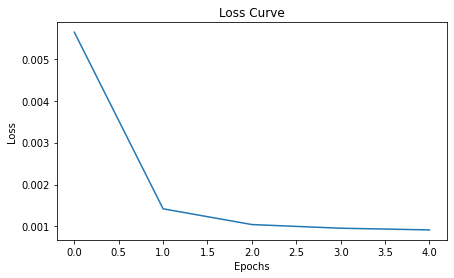

In [67]:
utils.plotLoss(history)

## Prediction
Now let us predict on the data of some radnom departments

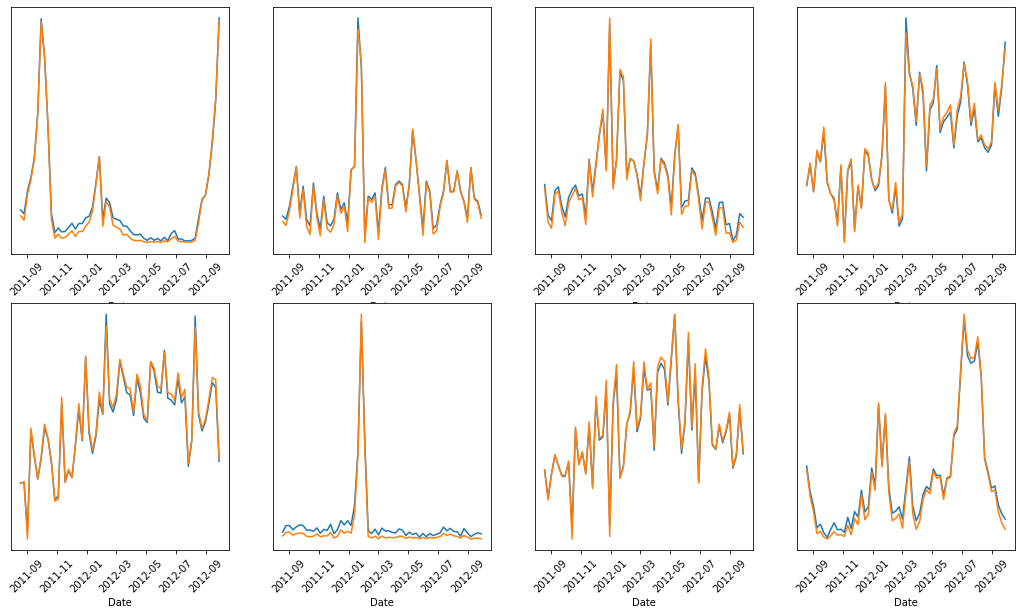

In [70]:
plt.figure(figsize = (18,10))
data = train.query("Store == 1 and Dept == 1")

for i in range(1,9):
  plt.subplot(2,4,i)
  time_seires_num = random.randint(0, len(test_labels))
  gen = test_features[time_seires_num]
  label_for_pred = test_labels[time_seires_num]
  pred = model.predict(gen)
  length = pred.shape[0]
  dates = data.Date[80:80+length]


  plt.xticks (rotation = 45)
  plt.yticks([])         
  # order = np.linspace(0,sth,sth)
  sns.lineplot(x=dates, y=label_for_pred[:length])
  sns.lineplot(x=dates, y=pred[:length,0])